In [83]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('darkgrid')

import missingno as msno
from sklearn.impute import SimpleImputer

# import arviz as az
# import pymc3 as pm
# from theano import tensor as tt

from fitter import Fitter, get_common_distributions, get_distributions
# import mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from scipy import signal

from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot

from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest

from sklearn.experimental import enable_iterative_imputer
from sklearn import linear_model

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

In [84]:
print(os.getcwd())
os.chdir('G:/My Drive/To_Do/MMM/Raw_Hain_Data')

G:\My Drive\To_Do\MMM\Raw_Hain_Data


In [85]:
df_dm = pd.read_csv('deutsch_matterkind.csv')
df_ts = pd.read_csv('Celestial_Trade_Spend_5_22.csv')
df_cd = pd.read_csv('celestial_data_16_22_22.csv')

C:\Users\norri\AppData\Local\Temp\ipykernel_1524\2724166531.py:1: DtypeWarning: Columns (8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_dm = pd.read_csv('deutsch_matterkind.csv')


In [86]:
def missing_values(df):
    segment = [var for var in df.columns if df[var].dtype == 'O']
    print('There are {} variables\n'.format(len(segment)))
    print('The variables are :\n\n', segment)
    print('The percentage missing of each of the variables is:\n')
    print(df[segment].isnull().sum() * 100/ len(df))
    print('The count of non-nulls for each of the variables is:\n')
    missing = df.select_dtypes(include=object)
    missing.info()

In [87]:
missing_values(df_dm)

There are 11 variables

The variables are :

 ['Source', 'Brand', 'Product Featured', 'Geography', 'Media_Type', 'Media_Platform', 'Media_Placement', 'Campaign Name', 'Creative Name', 'Video Length', 'Week End Date']
The percentage missing of each of the variables is:

Source               0.000000
Brand                0.000000
Product Featured     5.016667
Geography            0.000000
Media_Type           0.000000
Media_Platform       0.000000
Media_Placement      0.000000
Campaign Name        0.000000
Creative Name       70.737665
Video Length        99.618524
Week End Date        0.000000
dtype: float64
The count of non-nulls for each of the variables is:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139196 entries, 0 to 139195
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Source            139196 non-null  object
 1   Brand             139196 non-null  object
 2   Product Featured  132213 no

In [88]:
missing_values(df_cd)

There are 17 variables

The variables are :

 ['Brand', 'Product Featured', 'Retailer', 'Geography', 'Shopper Marketing Supplier', 'Shopper Marketing Type', 'Shopper Marketing Platform', 'Shopper Marketing Tactic', 'Campaign Name', 'Week Start Date (or Campaign Start Date)', 'Week End Date (or Campaign End Date)', 'Impressions', 'Redemptions', 'Working Cost', 'Clicks', 'Estimated % Reach', 'Any other metrics you have']
The percentage missing of each of the variables is:

Brand                                        1.071429
Product Featured                             1.071429
Retailer                                     1.071429
Geography                                    6.785714
Shopper Marketing Supplier                   1.071429
Shopper Marketing Type                       1.071429
Shopper Marketing Platform                  76.071429
Shopper Marketing Tactic                    24.642857
Campaign Name                                1.071429
Week Start Date (or Campaign Start Dat

In [89]:
missing_values(df_ts)

There are 8 variables

The variables are :

 ['Product Group L2', 'Plan Customer', 'Event Spend - Spend Type', 'Event (Text)', 'Event Spend(Text)', 'Event Spend - Instore Start Date', 'Event Spend - Instore End Date', ' LE Spend ']
The percentage missing of each of the variables is:

Product Group L2                    1.277372
Plan Customer                       1.277372
Event Spend - Spend Type            1.277372
Event (Text)                        1.277372
Event Spend(Text)                   1.277372
Event Spend - Instore Start Date    1.277372
Event Spend - Instore End Date      1.277372
 LE Spend                           1.277372
dtype: float64
The count of non-nulls for each of the variables is:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 8 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Product Group L2                  541 non-null    obj

In [90]:
df_dm_smaller = df_dm.drop(['Source', 'Brand', 'Product Featured', 'Geography'], axis=1)

In [91]:
df_dm_smaller.nunique()

Media_Type             7
Media_Platform      3509
Media_Placement       22
Campaign Name          7
Creative Name         42
Video Length           3
Week End Date         58
Impressions        10973
Working Cost        1082
Clicks               754
dtype: int64

In [92]:
# Imputing with MICE


# df_knn = df.filter(['Dig_Coupon_Imp', 'Dig_Coup_Cost',		'Dig_Demo_Cost',	'LCM_Imp',	'LCM_Cost',	'Paid_Search_Imp',	'Paid_Search_Cost',	'Signage_Imp',	'Signage Cost',	'Total_Imp',	'Total_Working_Cost'
#                      ], axis=1).copy()
#
# # df_knn = df.filter(['Distance','MaxSpeed','AvgSpeed','AvgMovingSpeed'], axis=1).copy()
#
# # Define scaler to set values between 0 and 1
#
# scaler = MinMaxScaler(feature_range=(0, 1))
# df_knn = pd.DataFrame(scaler.fit_transform(df_knn), columns = df_knn.columns)
#
# # Define KNN imputer and fill missing values
# knn_imputer = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
# df_knn_imputed = pd.DataFrame(knn_imputer.fit_transform(df_knn), columns=df_knn.columns)


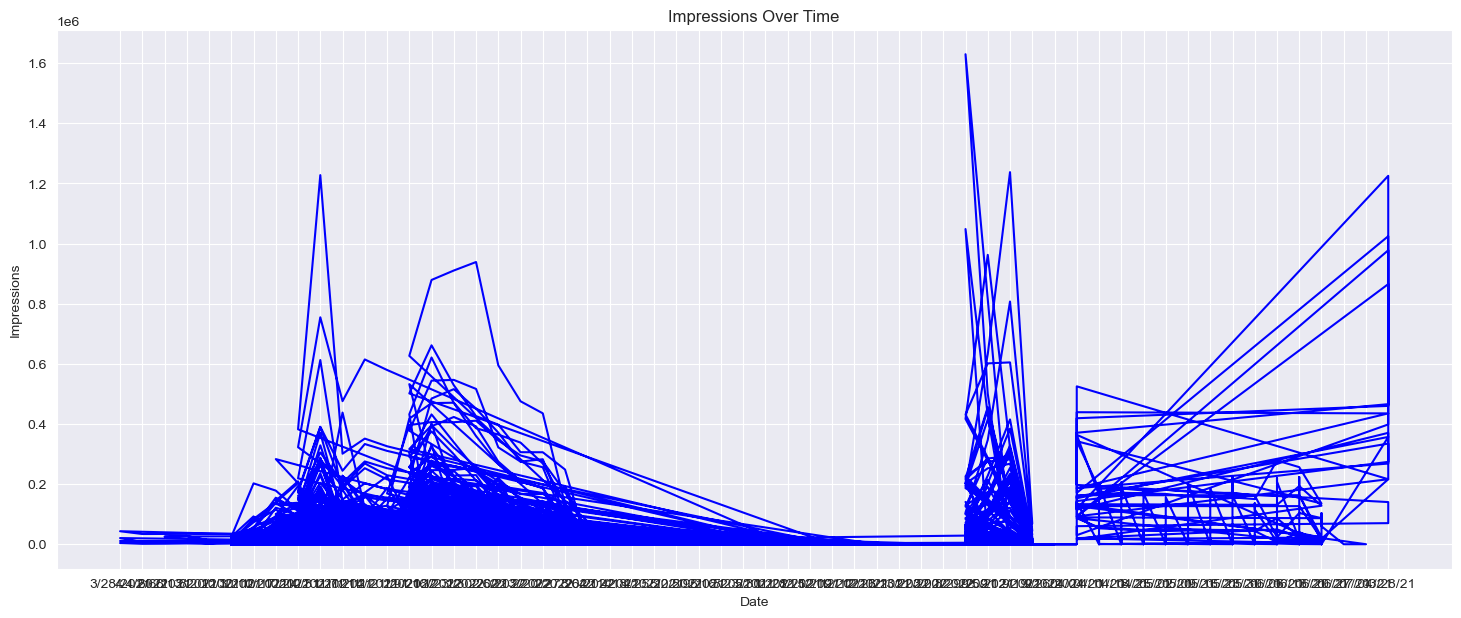

In [93]:
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Impressions', dpi=100):
    plt.figure(figsize=(18, 7), dpi=dpi)
    plt.plot(x, y, color='blue')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
plot_df(df_dm_smaller, df_dm_smaller['Week End Date'], df_dm_smaller['Impressions'], title='Impressions Over Time')

In [94]:
def unique(df):
    segment = [var for var in df.columns if df[var].dtype == 'O']
    print('There are {} numerical/continuous variables\n'.format(len(segment)))
    print('The numerical/continuous variables are :\n\n', segment)
    print(df[segment].isnull().sum() / len(df))
    df.info()
    df.describe()
    print(df.nunique())

In [95]:
unique(df_cd)

There are 17 numerical/continuous variables

The numerical/continuous variables are :

 ['Brand', 'Product Featured', 'Retailer', 'Geography', 'Shopper Marketing Supplier', 'Shopper Marketing Type', 'Shopper Marketing Platform', 'Shopper Marketing Tactic', 'Campaign Name', 'Week Start Date (or Campaign Start Date)', 'Week End Date (or Campaign End Date)', 'Impressions', 'Redemptions', 'Working Cost', 'Clicks', 'Estimated % Reach', 'Any other metrics you have']
Brand                                       0.010714
Product Featured                            0.010714
Retailer                                    0.010714
Geography                                   0.067857
Shopper Marketing Supplier                  0.010714
Shopper Marketing Type                      0.010714
Shopper Marketing Platform                  0.760714
Shopper Marketing Tactic                    0.246429
Campaign Name                               0.010714
Week Start Date (or Campaign Start Date)    0.010714
Week 

In [96]:
unique(df_dm)

There are 11 numerical/continuous variables

The numerical/continuous variables are :

 ['Source', 'Brand', 'Product Featured', 'Geography', 'Media_Type', 'Media_Platform', 'Media_Placement', 'Campaign Name', 'Creative Name', 'Video Length', 'Week End Date']
Source              0.000000
Brand               0.000000
Product Featured    0.050167
Geography           0.000000
Media_Type          0.000000
Media_Platform      0.000000
Media_Placement     0.000000
Campaign Name       0.000000
Creative Name       0.707377
Video Length        0.996185
Week End Date       0.000000
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139196 entries, 0 to 139195
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Source            139196 non-null  object 
 1   Brand             139196 non-null  object 
 2   Product Featured  132213 non-null  object 
 3   Geography         139196 non-null  object 
 4   Med

In [97]:
unique(df_ts)

There are 8 numerical/continuous variables

The numerical/continuous variables are :

 ['Product Group L2', 'Plan Customer', 'Event Spend - Spend Type', 'Event (Text)', 'Event Spend(Text)', 'Event Spend - Instore Start Date', 'Event Spend - Instore End Date', ' LE Spend ']
Product Group L2                    0.012774
Plan Customer                       0.012774
Event Spend - Spend Type            0.012774
Event (Text)                        0.012774
Event Spend(Text)                   0.012774
Event Spend - Instore Start Date    0.012774
Event Spend - Instore End Date      0.012774
 LE Spend                           0.012774
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 548 entries, 0 to 547
Data columns (total 8 columns):
 #   Column                            Non-Null Count  Dtype 
---  ------                            --------------  ----- 
 0   Product Group L2                  541 non-null    object
 1   Plan Customer                     541 non-null    object

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

df_vif = df_dm_smaller.select_dtypes(exclude='object')
df_vif.describe()

C:\Users\norri\AppData\Local\Temp\ipykernel_1524\564024522.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_dm_smaller.corr(method="spearman").round(2)


,Impressions,Working Cost,Clicks
count,3.000000,3.000000,3.000000
mean,0.576667,0.476667,0.660000
std,0.458294,0.470142,0.330454
min,0.090000,0.090000,0.340000
25%,0.365000,0.215000,0.490000
50%,0.640000,0.340000,0.640000
75%,0.820000,0.670000,0.820000
max,1.000000,1.000000,1.000000


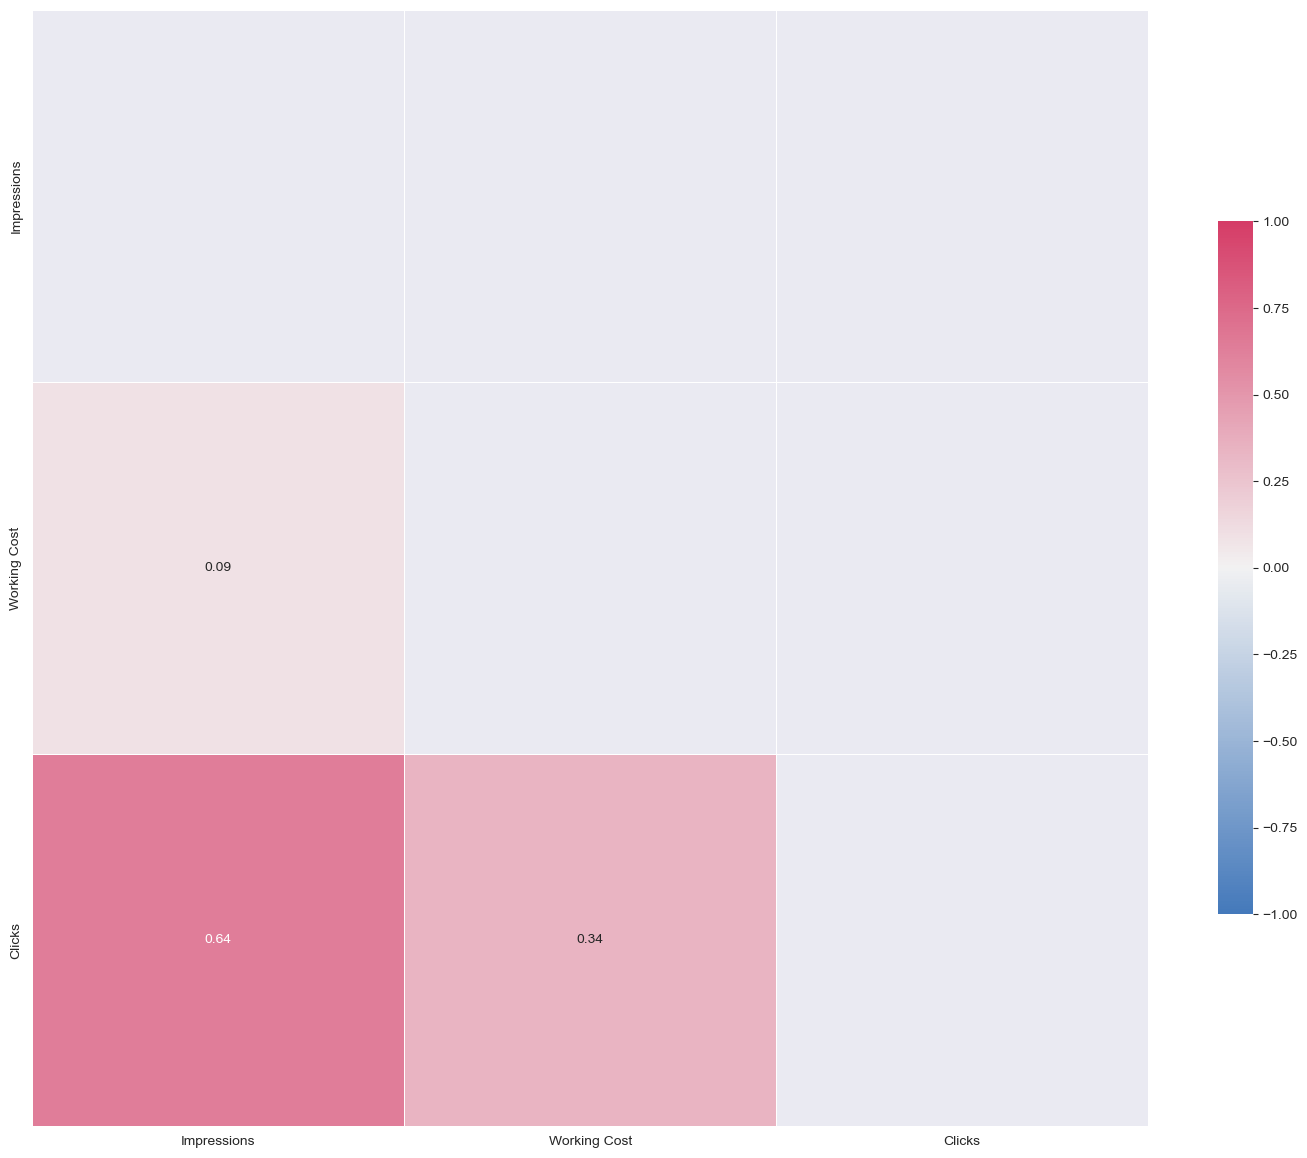

In [103]:
corr = df_dm_smaller.corr(method="spearman").round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(250, 1, as_cmap=True)
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
corr.describe()

In [104]:
# use VIF along with variable importance to check new dataframes
vif_df = df_dm_smaller[~df_dm_smaller.isin([np.nan, np.inf, -np.inf]).any(1)]

X = vif_df
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

C:\Users\norri\AppData\Local\Temp\ipykernel_1524\1578846184.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.any and Series.any will be keyword-only.
  vif_df = df_dm_smaller[~df_dm_smaller.isin([np.nan, np.inf, -np.inf]).any(1)]


ValueError: zero-size array to reduction operation maximum which has no identity

C:\Users\norri\AppData\Local\Temp\ipykernel_1524\101545230.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_vif = vif_df.corr(method="spearman").round(2)


,Impressions,Working Cost,Clicks
count,0.0,0.0,0.0
mean,NaN,NaN,NaN
std,NaN,NaN,NaN
min,NaN,NaN,NaN
25%,NaN,NaN,NaN
50%,NaN,NaN,NaN
75%,NaN,NaN,NaN
max,NaN,NaN,NaN


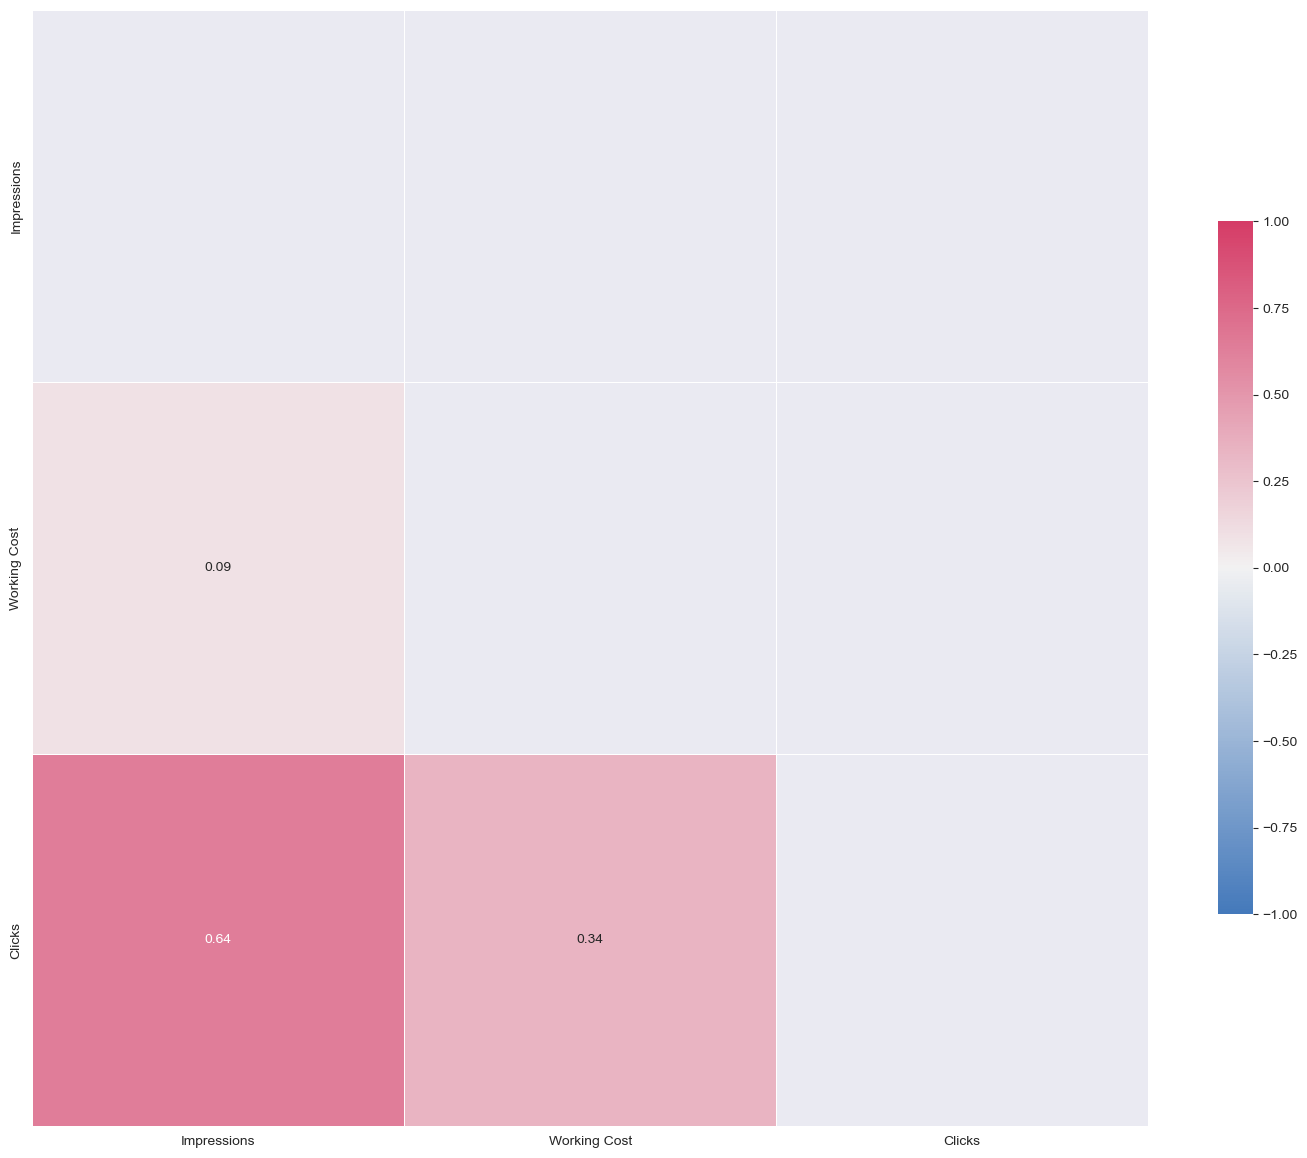

In [105]:
corr_vif = vif_df.corr(method="spearman").round(2)
mask = np.triu(np.ones_like(corr_vif, dtype=bool))
plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(250, 1, as_cmap=True)
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
corr_vif.describe()

In [110]:
adf_test = ADFTest(alpha = .05)
adf_test.should_diff(df_dm['Impressions'])

(0.01, False)

In [ ]:
# figure, axes = plt.subplots(5, 3, figsize=(15, 15))
# sns.kdeplot(ax=axes[0, 0], x='Dig_Coup_Cost', data=df_num)
# sns.kdeplot(ax=axes[0, 1], x='Dig_Coupon_Imp', data=df_num)
# sns.kdeplot(ax=axes[0, 2], x='Dig_Demo_Cost', data=df_num)
# sns.kdeplot(ax=axes[1, 0], x='Dig_Demo_Imp', data=df_num)
# sns.kdeplot(ax=axes[1, 1], x='LCM_Cost', data=df_num)
# sns.kdeplot(ax=axes[1, 2], x='LCM_Imp', data=df_num)
# sns.kdeplot(ax=axes[2, 0], x='Dig_Demo_Imp', data=df_num)
# sns.kdeplot(ax=axes[2, 1], x='LCM_Cost', data=df_num)
# sns.kdeplot(ax=axes[2, 2], x='LCM_Imp', data=df_num)
# sns.kdeplot(ax=axes[3, 0], x='Paid_Search_Cost', data=df_num)
# sns.kdeplot(ax=axes[3, 1], x='Paid_Search_Imp', data=df_num)
# sns.kdeplot(ax=axes[3, 2], x='Signage_Cost', data=df_num)
# sns.kdeplot(ax=axes[4, 0], x='Signage_Imp', data=df_num)
# sns.kdeplot(ax=axes[4, 1], x='Total_Imp', data=df_num)
# sns.kdeplot(ax=axes[4, 2], x='Total_Working_Cost', data=df_num)
# plt.show()

Selecting from the most likely distributions of the data,
finds the most likely distribution for the data, its parameters,
and is useful for any data transformations.

In [112]:
dist_list = ['gamma', 'expon', 'cauchy', 'norm', 'uniform']

for var in df_dm_smaller:
    dist_test = df_dm_smaller[var].dropna()
    dist_test = dist_test.values
    f = Fitter(dist_test, distributions=dist_list, timeout=60)
    f.fit()
    print(var)
    print(f.summary(plot=False))
    print(f.get_best(method='sumsquare_error'))

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

Text(0.5, 1.0, 'Sales Detrended')

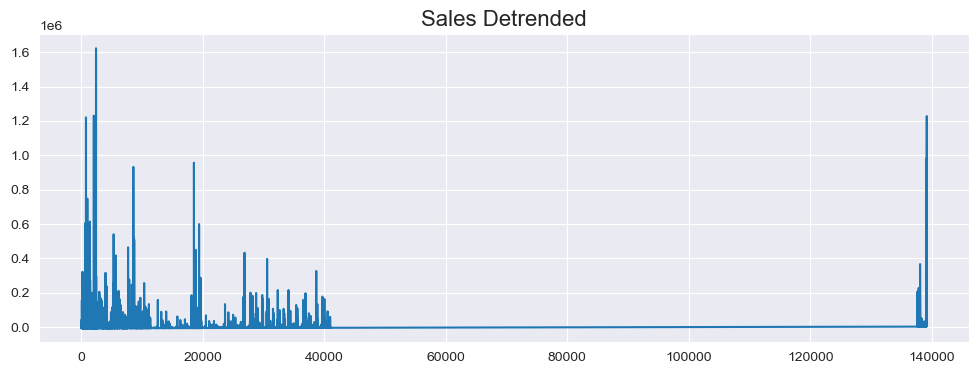

In [114]:
detrended = signal.detrend(df_dm_smaller['Impressions'].values)
plt.rcParams.update({'figure.figsize': (12,4)})
plt.plot(detrended)
plt.title('Sales Detrended', fontsize=16)

In [116]:
result_mul = seasonal_decompose(df_dm_smaller['Impressions'].values, model='multiplicative', period=52)
deseasonalized = df_dm_smaller['Total_Imp'].values / result_mul.seasonal
plt.plot(deseasonalized)
plt.title('Impressions Deseasonalized', fontsize=16)
plt.plot()

ValueError: Multiplicative seasonality is not appropriate for zero and negative values

<AxesSubplot: xlabel='Lag', ylabel='Autocorrelation'>

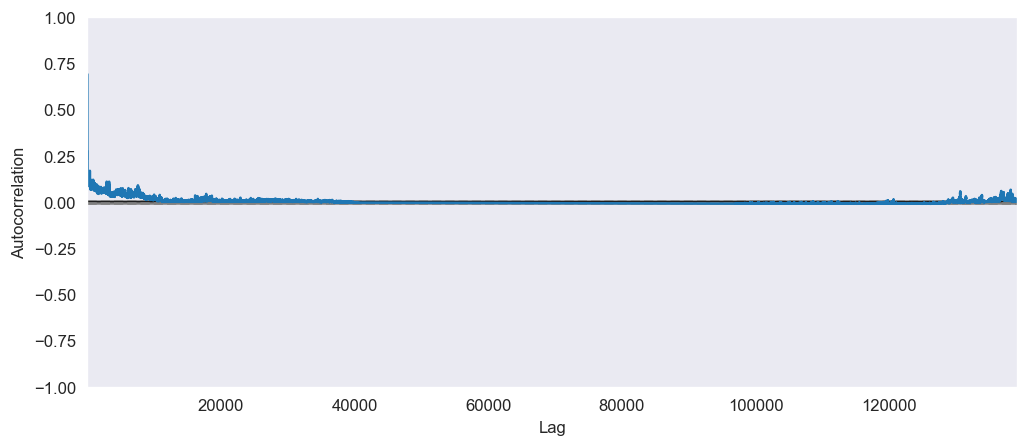

In [118]:
plt.rcParams.update({'figure.figsize':(10,4), 'figure.dpi':120})
autocorrelation_plot(df_dm_smaller['Impressions'].tolist())

In [ ]:
df.to_csv('df_mean.csv', encoding='utf-8', index=False)